# Sentiment Analysis of Amazon Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('bmh')
plt.rcParams.update({'font.size': 7, 'font.family': 'monospace'})

In [2]:
# Import data
df = pd.read_csv('../data/amazon_reviews.csv')
df = df.head(500)
df = df.reset_index()
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


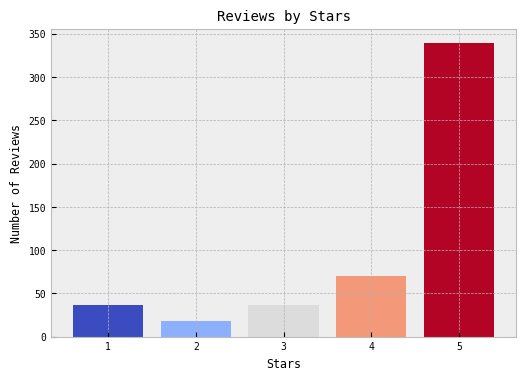

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   500 non-null    int64 
 1   Id                      500 non-null    int64 
 2   ProductId               500 non-null    object
 3   UserId                  500 non-null    object
 4   ProfileName             500 non-null    object
 5   HelpfulnessNumerator    500 non-null    int64 
 6   HelpfulnessDenominator  500 non-null    int64 
 7   Score                   500 non-null    int64 
 8   Time                    500 non-null    int64 
 9   Summary                 500 non-null    object
 10  Text                    500 non-null    object
dtypes: int64(6), object(5)
memory usage: 43.1+ KB


In [3]:
# Exploratory analysis
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap = cmap(np.linspace(0, 1, 5))
ax = df['Score'].value_counts().sort_index().plot(
    kind='bar',
    title='Reviews by Stars',
    figsize=(6, 4), 
    color=cmap,
    width=0.8
    )

ax.set_xlabel('Stars')
ax.set_ylabel('Number of Reviews')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

df.info()

## VADER Sentiment Scoring

Vader (Valence Aware Dictionary and sEntiment Reasoner) is a pre-trained sentiment analysis model. VADER analyzes text based on a predefined list of words and their associated sentiment scores.
- PROS: easy to use and handles informal text.
- CONS: limited contextual understanding and domain dependence.

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [5]:
# Test the sentiment analyzer object
print(sia.polarity_scores('I love this product'))
print(sia.polarity_scores('I hate this product'))
print(sia.polarity_scores('I love this product so much'))
print(sia.polarity_scores('I hate this product so much'))

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}
{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}
{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}
{'neg': 0.481, 'neu': 0.519, 'pos': 0.0, 'compound': -0.5719}


In [39]:
# Apply the sentiment analyzer to the reviews
res_vader = {}
for i in range(len(df)):
    row = df.iloc[i]
    text = row['Text']
    res_vader[i]= sia.polarity_scores(text)
    # change header names to vader_*
    res_vader[i] = {f'vader_{k}': v for k, v in res_vader[i].items()}
    
vader = pd.DataFrame(res_vader).T
vader = vader.reset_index()
vader = vader.merge(df, on='index', how='left')
vader = vader.drop(columns=['index', 'Id'])   

vader.head()

,vader_neg,vader_neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


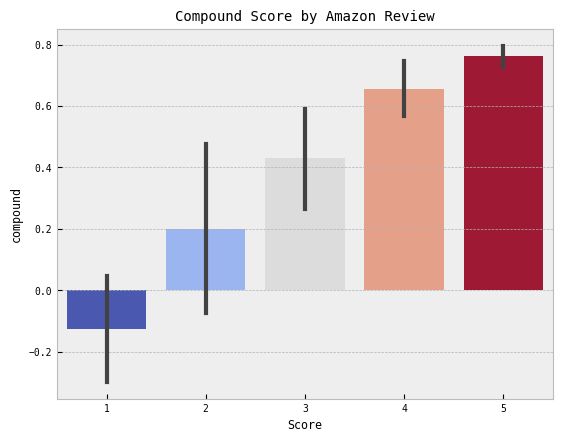

In [7]:
ax = sns.barplot(data=vader, x='Score', y='compound', palette=list(cmap), hue='Score')
ax.set_title('Compound Score by Amazon Review')
ax.get_legend().remove()
plt.show()

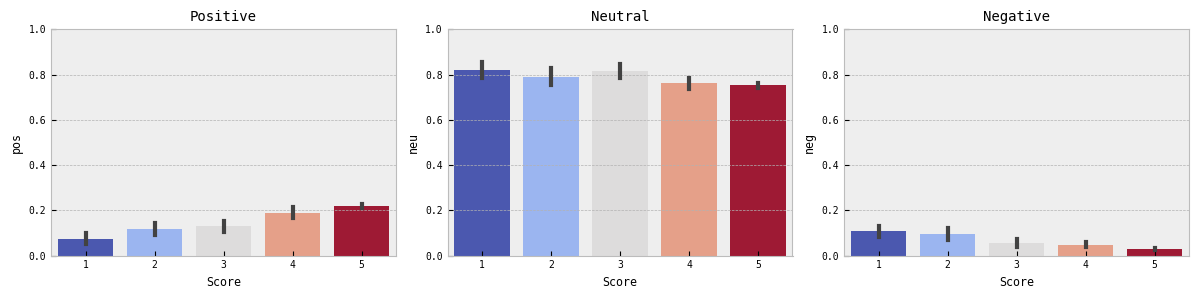

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vader, x='Score', y='pos', ax=axs[0], palette=list(cmap), hue='Score')
sns.barplot(data=vader, x='Score', y='neu', ax=axs[1], palette=list(cmap), hue='Score')
sns.barplot(data=vader, x='Score', y='neg', ax=axs[2], palette=list(cmap), hue='Score')
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.get_legend().remove()
plt.tight_layout()
plt.show()

## RoBERTa Pretrained Model
This is a roBERTa-base model trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark. 

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
# Transfer learning model with predefined model weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [62]:
# Run RoBERTa

def run_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict
    
sentiment_analysis = {}
res_vader = {}

for i in range(len(df)):
    try:
        print(f'Processed {i+1} out of {len(df)} reviews', end='\r')
        row = df.iloc[i]
        text = row['Text']
        myid = row['Id']
        sentiment_analysis[myid] = run_roberta(text)
        sentiment_analysis[myid].update(sia.polarity_scores(text))
        sentiment_analysis[myid]['Score'] = row['Score']
        sentiment_analysis[myid]['Text'] = row['Text']
        sentiment_analysis[myid]['Summary'] = row['Summary']
        sentiment_analysis[myid]['Time'] = row['Time']
        sentiment_analysis[myid]['ProfileName'] = row['ProfileName']
        sentiment_analysis[myid]['ProductId'] = row['ProductId']
        sentiment_analysis[myid]['HelpfulnessNumerator'] = row['HelpfulnessNumerator']
        sentiment_analysis[myid]['HelpfulnessDenominator'] = row['HelpfulnessDenominator']
    except RuntimeError:
        print(f'\nError with {i+1}\n')

Processed 83 out of 500 reviews
Error with 83

Processed 187 out of 500 reviews
Error with 187



In [65]:
sentiment_analysis = pd.DataFrame(sentiment_analysis).T
sentiment_analysis = sentiment_analysis.rename(columns={'neg': 'vader_neg', 'neu': 'vader_neu', 'pos': 'vader_pos', 'compound': 'vader_compound'})
sentiment_analysis

,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,Score,Text,Summary,Time,ProfileName,ProductId,HelpfulnessNumerator,HelpfulnessDenominator
1,0.009624,0.04998,0.940395,0.0,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,1303862400,delmartian,B001E4KFG0,1,1
2,0.508986,0.452414,0.0386,0.138,0.862,0.0,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1346976000,dll pa,B00813GRG4,0,0
3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...,"""Delight"" says it all",1219017600,"Natalia Corres ""Natalia Corres""",B000LQOCH0,1,1
4,0.002295,0.090219,0.907485,0.0,1.0,0.0,0.0,2,If you are looking for the secret ingredient i...,Cough Medicine,1307923200,Karl,B000UA0QIQ,3,3
5,0.001635,0.010302,0.988063,0.0,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...,Great taffy,1350777600,"Michael D. Bigham ""M. Wassir""",B006K2ZZ7K,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.001906,0.009862,0.988232,0.0,0.554,0.446,0.9725,5,i rarely eat chips but i saw these and tried t...,amazing chips,1201392000,Darren,B000G6RYNE,0,0
497,0.004415,0.034215,0.961369,0.059,0.799,0.142,0.7833,5,This is easily the best potato chip that I hav...,Best Chip Ever,1196726400,Keith,B000G6RYNE,0,0
498,0.006427,0.074537,0.919036,0.025,0.762,0.212,0.9848,4,Kettle Chips Spicy Thai potato chips have the ...,"Tangy, spicy, and sweet- oh my!",1186617600,bubbles,B000G6RYNE,0,0
499,0.865614,0.119366,0.01502,0.041,0.904,0.055,0.128,4,"Okay, I should not eat potato chips, nor shoul...",An indulgence with a bite,1184198400,Bruce G. Lindsay,B000G6RYNE,0,0


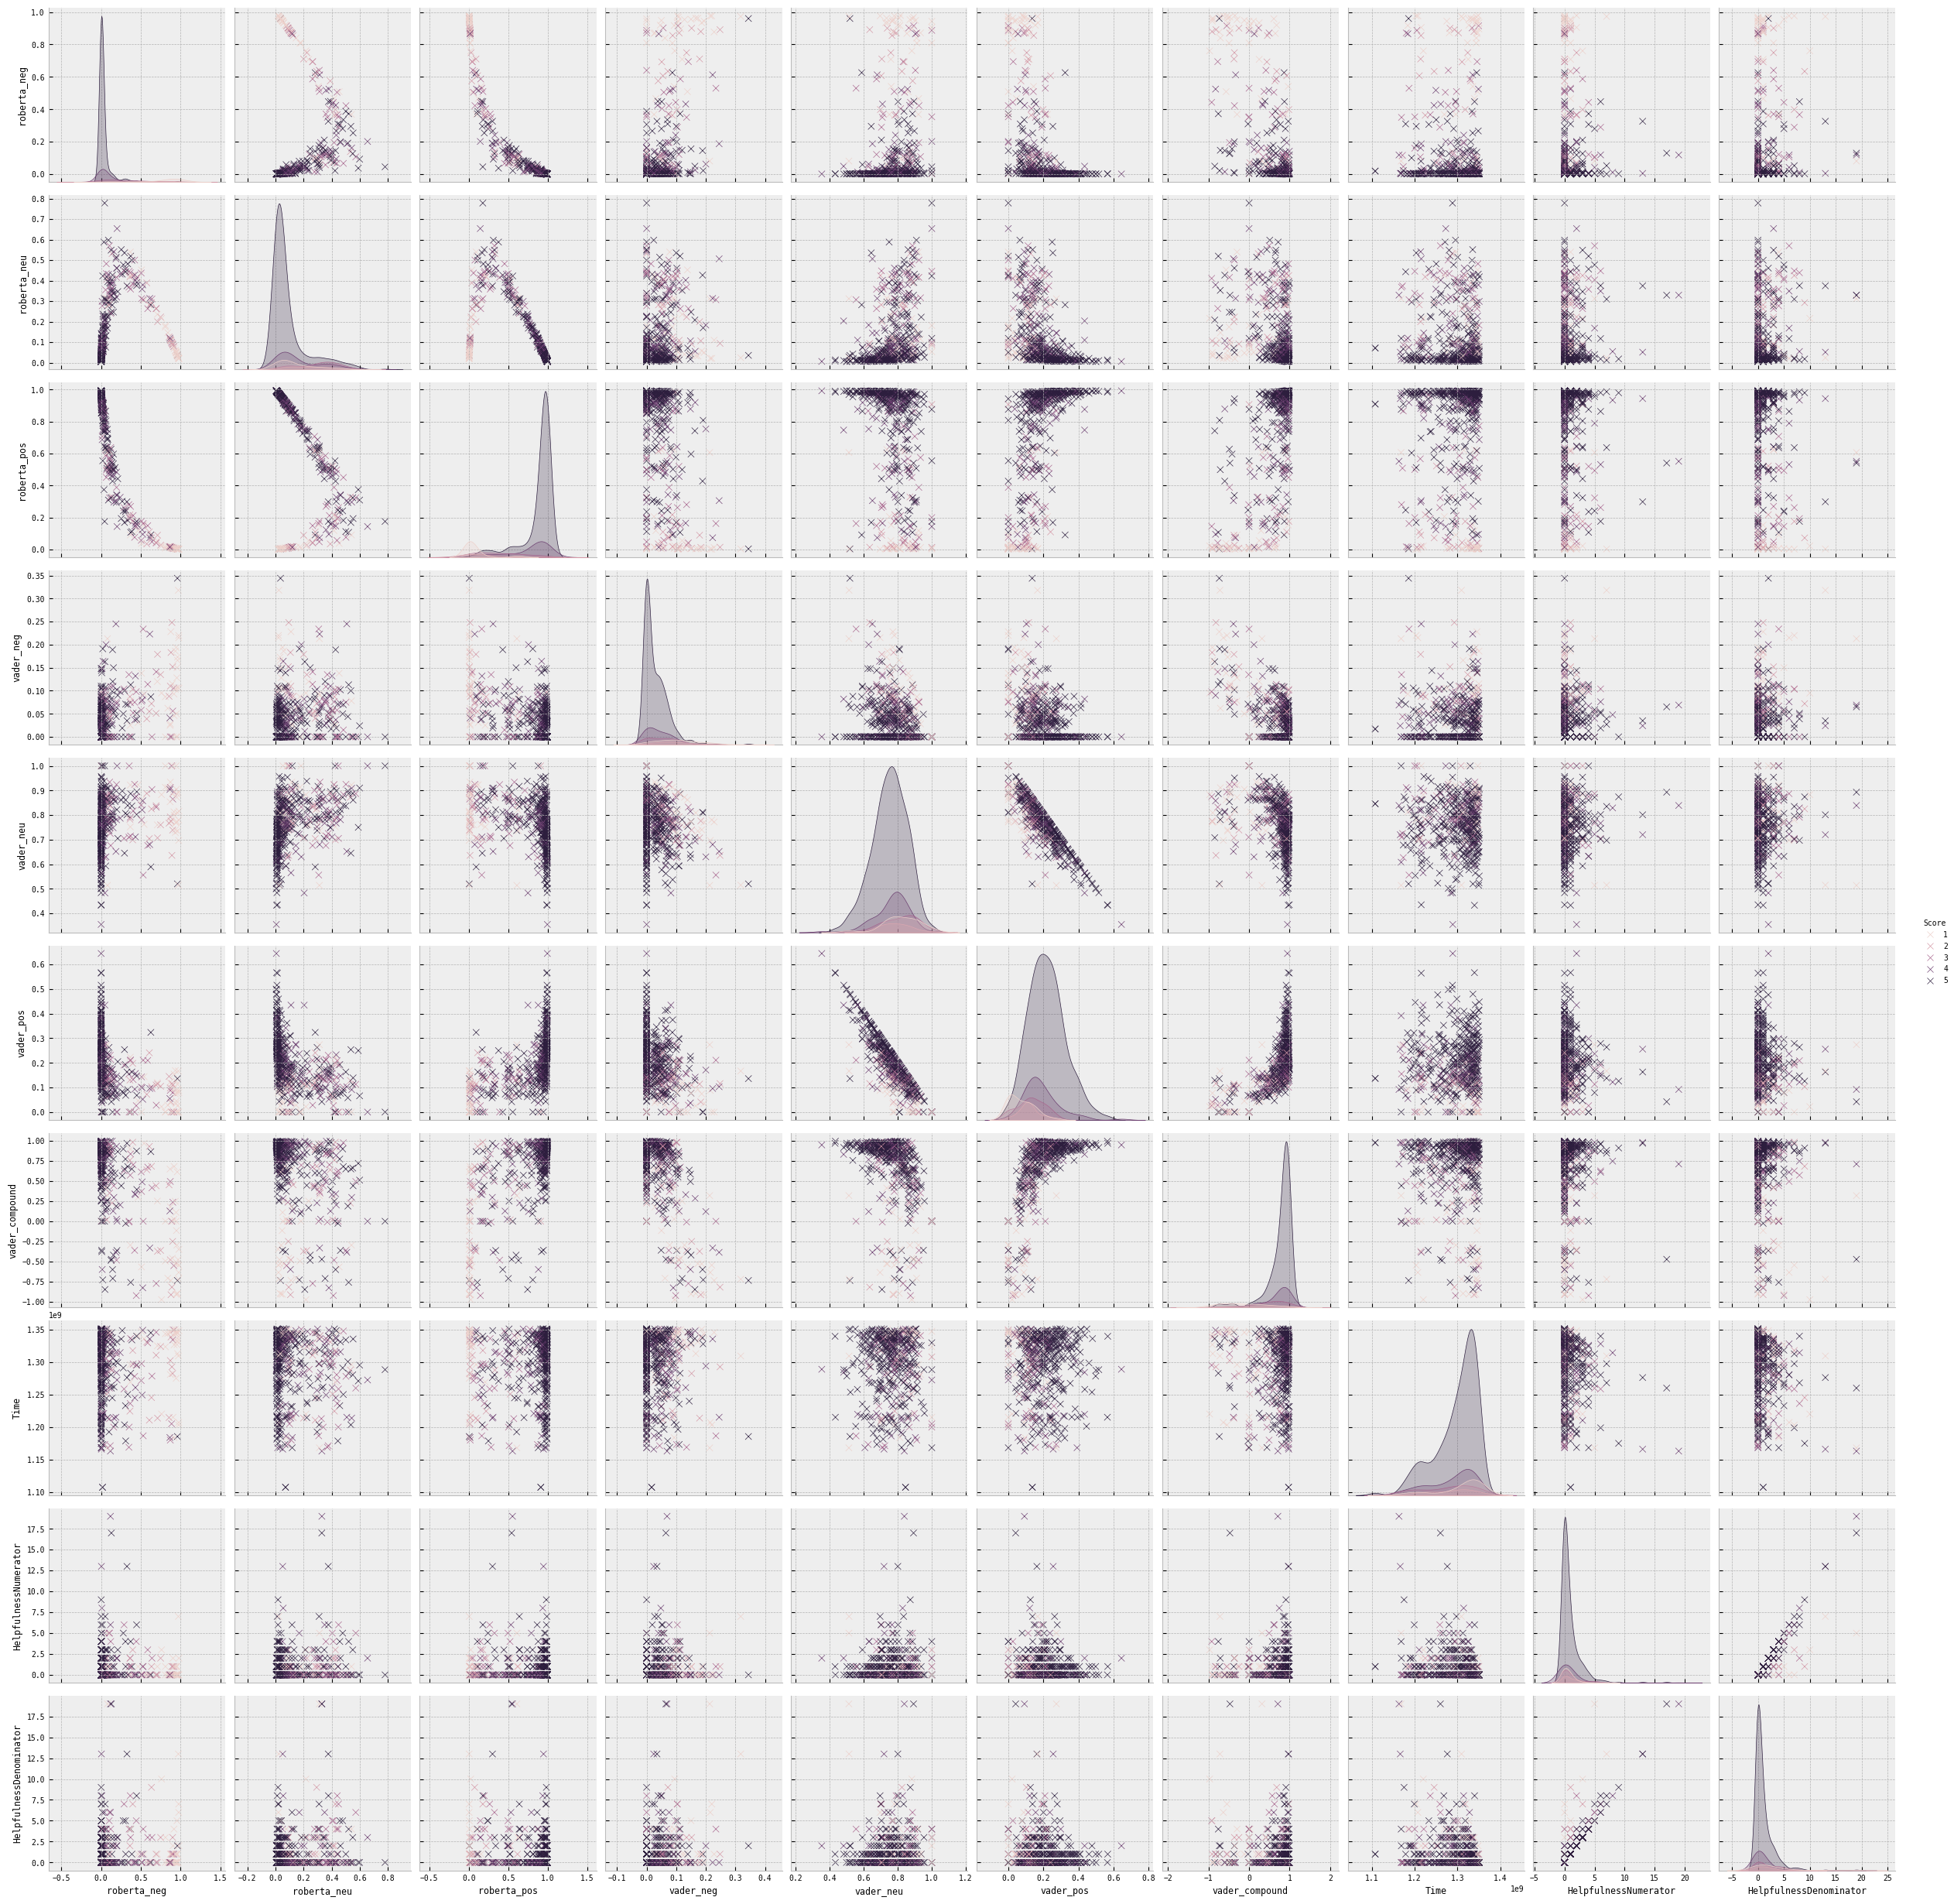

In [87]:
# compare vader and roberta with a pairplot
sns.pairplot(
    data=sentiment_analysis, 
    markers='x',
    vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], 
    hue='Score', palette=['red', 'orange', 'goldenrod', 'green', 'blue'],
    plot_kws={'alpha': 0.5}
    )
plt.show()
